In [34]:
import pandas as pd
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json

torch.set_float32_matmul_precision('medium')


In [35]:
target_columns = [
    'Temperature','Humidity','Soil_Moisture','Soil_Temperature','Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [36]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [37]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.0005, patience=15, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TSMixerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=96,
        output_chunk_length=24,
        n_epochs=100,
        batch_size=72,
        dropout=0.45,
        ff_size=147,
        num_blocks=3,
        hidden_size=40,
        normalize_before=False,
        norm_type="LayerNormNoBias",
        activation="GELU",
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.L1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":7, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.004631076157876628, "weight_decay":5.055631463203692e-06},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )

    model.load_from_checkpoint(f"model_{fold+1}/", best=True)

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 10.617
Metric val_loss improved by 0.061 >= min_delta = 0.0005. New best score: 10.556
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 10.554
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 10.548
Metric val_loss improved by 0.004 >= min_delta = 0.0005. New best score: 10.544
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 10.541
Monitored metric val_loss did not improve in the last 15 records. Best score: 10.541. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.504306e+01     6.711413     5.675122  0.037766   
Humidity                   3.432544e+02    18.527126    15.585427 -0.112277   
Soil_Moisture              1.609002e+06  1268.464580  1031.385653 -0.297423   
Soil_Temperature           6.719037e+01     8.196973     6.800305 -0.171843   
Precipitation_accumulated  6.137290e+04   247.735536   137.610504 -0.445733   

                               SMAPE      WMAPE  
Temperature                33.419436  34.374609  
Humidity                   23.037183  20.494844  
Soil_Moisture              13.036980  12.934041  
Soil_Temperature           38.020565  41.548967  
Precipitation_accumulated  88.671910  98.008153  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.543817e+01     6.740784     5.697414  0.030582   
Humidity                   3.516461e+02    18.752230    15.849265 -0.137528   
Soil_Moisture              1.598880e+06  1264.468154  1029.385521 -0.288364   
Soil_Temperature           6.738187e+01     8.208646     6.810273 -0.173686   
Precipitation_accumulated  6.151532e+04   248.022826   137.931162 -0.447222   

                               SMAPE      WMAPE  
Temperature                33.522565  34.487627  
Humidity                   23.538385  20.847604  
Soil_Moisture              13.017020  12.912482  
Soil_Temperature           38.098243  41.579778  
Precipitation_accumulated  88.888087  98.012156  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.692356e+01     6.850078     5.793897  0.000824   
Humidity                   3.577016e+02    18.913001    16.077398 -0.154783   
Soil_Moisture              1.593276e+06  1262.250225  1028.951661 -0.282369   
Soil_Temperature           6.935722e+01     8.328098     6.930864 -0.205601   
Precipitation_accumulated  6.170166e+04   248.398191   138.351807 -0.449114   

                               SMAPE      WMAPE  
Temperature                33.834014  35.053073  
Humidity                   23.868676  21.156376  
Soil_Moisture              13.015861  12.911505  
Soil_Temperature           38.587354  42.289038  
Precipitation_accumulated  89.070547  98.010952  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.545106e+01     6.741740     5.706485  0.026916   
Humidity                   3.673838e+02    19.167258    16.334820 -0.186812   
Soil_Moisture              1.589780e+06  1260.864738  1029.444021 -0.277442   
Soil_Temperature           6.739354e+01     8.209357     6.842886 -0.185610   
Precipitation_accumulated  6.190091e+04   248.798937   138.794123 -0.451300   

                               SMAPE      WMAPE  
Temperature                33.509688  34.594420  
Humidity                   24.285089  21.479419  
Soil_Moisture              13.025371  12.921561  
Soil_Temperature           38.289726  41.864985  
Precipitation_accumulated  89.383078  98.023191  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.683170e+01     6.843369     5.802256 -0.013533   
Humidity                   3.887866e+02    19.717672    16.842168 -0.262129   
Soil_Moisture              1.570929e+06  1253.366874  1028.977598 -0.260727   
Soil_Temperature           6.755422e+01     8.219137     6.858163 -0.203280   
Precipitation_accumulated  6.209151e+04   249.181686   139.224019 -0.453273   

                               SMAPE      WMAPE  
Temperature                33.940138  35.270749  
Humidity                   25.159240  22.121311  
Soil_Moisture              13.023907  12.920110  
Soil_Temperature           38.459560  42.090571  
Precipitation_accumulated  89.609344  98.024730  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.777608e+01     6.912024     5.852717 -0.036065   
Humidity                   3.768768e+02    19.413314    16.512573 -0.223274   
Soil_Moisture              1.584051e+06  1258.590705  1029.794818 -0.269760   
Soil_Temperature           6.882664e+01     8.296182     6.918444 -0.225276   
Precipitation_accumulated  6.228014e+04   249.559889   139.650433 -0.455191   

                               SMAPE      WMAPE  
Temperature                34.106768  35.631872  
Humidity                   24.652835  21.675673  
Soil_Moisture              13.035975  12.934871  
Soil_Temperature           38.690146  42.511734  
Precipitation_accumulated  89.759518  98.021923  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE        R2  \
Temperature                4.805954e+01     6.932499     5.864795 -0.039030   
Humidity                   3.921859e+02    19.803683    16.883217 -0.269021   
Soil_Moisture              1.585446e+06  1259.145112  1034.006186 -0.269654   
Soil_Temperature           6.883485e+01     8.296677     6.918549 -0.221672   
Precipitation_accumulated  6.247831e+04   249.956610   140.095816 -0.457322   

                               SMAPE      WMAPE  
Temperature                34.260228  35.699710  
Humidity                   25.143296  22.164258  
Soil_Moisture              13.089143  12.992565  
Soil_Temperature           38.788024  42.504638  
Precipitation_accumulated  90.094269  98.030502  
O MSE desse fold foi 329686.7598677142

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.182
Metric val_loss improved by 0.031 >= min_delta = 0.0005. New best score: 0.151
Metric val_loss improved by 0.022 >= min_delta = 0.0005. New best score: 0.129
Metric val_loss improved by 0.008 >= min_delta = 0.0005. New best score: 0.121
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.119
Metric val_loss improved by 0.009 >= min_delta = 0.0005. New best score: 0.110
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.110. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.297087e+01     5.742027    4.552182   
Humidity                   1.618554e+02    12.722241   10.186574   
Soil_Moisture              1.134525e+06  1065.140626  949.327723   
Soil_Temperature           3.602978e+01     6.002481    4.944557   
Precipitation_accumulated  2.286514e+02    15.121222   11.872156   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.347615  28.756858  29.535146  
Humidity                       -6.731513  12.268387  11.840402  
Soil_Moisture                -219.981749  13.652514  14.875342  
Soil_Temperature               -3.363854  32.853690  32.053985  
Precipitation_accumulated -131869.418720   2.609339   2.591446  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.285570e+01     5.731989    4.565469   
Humidity                   1.608826e+02    12.683951   10.158390   
Soil_Moisture              1.121500e+06  1059.009095  944.613166   
Soil_Temperature           3.574728e+01     5.978903    4.961630   
Precipitation_accumulated  2.457999e+02    15.678007   12.365377   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.366882  29.093515  29.647202  
Humidity                       -6.682928  12.226861  11.806268  
Soil_Moisture                -220.428091  13.592602  14.802476  
Soil_Temperature               -3.357798  33.420706  32.191797  
Precipitation_accumulated -143255.814853   2.731281   2.699105  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.321018e+01     5.762828    4.593141   
Humidity                   1.612143e+02    12.697019   10.184551   
Soil_Moisture              1.125716e+06  1060.997457  945.982746   
Soil_Temperature           3.618372e+01     6.015291    4.959477   
Precipitation_accumulated  2.504479e+02    15.825544   12.489728   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.450267  29.196772  29.858371  
Humidity                       -6.716065  12.289256  11.834103  
Soil_Moisture                -225.343814  13.611294  14.825279  
Soil_Temperature               -3.440317  33.212835  32.210734  
Precipitation_accumulated -148074.010477   2.762042   2.726246  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.238823e+01     5.691066    4.542767   
Humidity                   1.631381e+02    12.772551   10.270524   
Soil_Moisture              1.132152e+06  1064.026431  949.793848   
Soil_Temperature           3.509780e+01     5.924340    4.897745   
Precipitation_accumulated  2.519381e+02    15.872558   12.501482   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.362765  29.004026  29.557637  
Humidity                       -6.833623  12.406273  11.931172  
Soil_Moisture                -230.476488  13.664128  14.886296  
Soil_Temperature               -3.325244  32.891834  31.838017  
Precipitation_accumulated -151170.019388   2.769440   2.728810  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.290114e+01     5.735951    4.559520   
Humidity                   1.670093e+02    12.923208   10.393922   
Soil_Moisture              1.128006e+06  1062.076135  949.312254   
Soil_Temperature           3.611805e+01     6.009830    4.946384   
Precipitation_accumulated  3.270350e+02    18.084108   13.791030   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.444774  28.958924  29.689538  
Humidity                       -7.050743  12.603885  12.071521  
Soil_Moisture                -233.491695  13.660109  14.880025  
Soil_Temperature               -3.461184  33.077392  32.178767  
Precipitation_accumulated -199234.438657   3.080329   3.010289  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.414086e+01     5.843018    4.634282   
Humidity                   1.701996e+02    13.046058   10.505822   
Soil_Moisture              1.141799e+06  1068.550158  955.493119   
Soil_Temperature           3.779129e+01     6.147462    5.048326   
Precipitation_accumulated  2.699433e+02    16.429950   13.270057   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.629115  29.299043  30.201045  
Humidity                       -7.250623  12.692021  12.198111  
Soil_Moisture                -240.326415  13.742923  14.978184  
Soil_Temperature               -3.683167  33.658266  32.869233  
Precipitation_accumulated -167045.925240   2.931635   2.896570  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE  \
Temperature                3.269898e+01     5.718302    4.540636   
Humidity                   1.674084e+02    12.938640   10.409593   
Soil_Moisture              1.141192e+06  1068.265933  957.321818   
Soil_Temperature           3.535824e+01     5.946279    4.891965   
Precipitation_accumulated  3.415629e+02    18.481421   14.002969   

                                      R2      SMAPE      WMAPE  
Temperature                    -3.469248  28.869769  29.621820  
Humidity                       -7.163691  12.616653  12.082988  
Soil_Moisture                -244.529832  13.771707  15.008161  
Soil_Temperature               -3.410789  32.778637  31.883894  
Precipitation_accumulated -214799.548581   3.130983   3.056547  
O MSE desse fold foi 228353.82639109585

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 

Metric val_loss improved. New best score: 0.083
Metric val_loss improved by 0.031 >= min_delta = 0.0005. New best score: 0.052
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.049
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 0.048
Metric val_loss improved by 0.004 >= min_delta = 0.0005. New best score: 0.044
Metric val_loss improved by 0.001 >= min_delta = 0.0005. New best score: 0.043
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.043. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    7.619429    2.760331    2.173996   -13.575233   
Humidity                      38.034422    6.167205    5.287644    -2.921646   
Soil_Moisture              89378.059282  298.961635  272.240388    -1.818463   
Soil_Temperature              11.319616    3.364464    2.663588   -63.809183   
Precipitation_accumulated    369.557565   19.223880   14.839118 -9274.289495   

                               SMAPE      WMAPE  
Temperature                30.227634  23.520833  
Humidity                    5.865323   5.809259  
Soil_Moisture               4.524845   4.595287  
Soil_Temperature           36.172395  27.292989  
Precipitation_accumulated   3.326965   3.236923  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    7.471199    2.733349    2.147877    -13.375196   
Humidity                      39.581906    6.291415    5.346913     -3.073205   
Soil_Moisture              93291.608346  305.436750  278.859654     -1.945111   
Soil_Temperature              11.115077    3.333928    2.635853    -63.970698   
Precipitation_accumulated    446.022622   21.119248   17.190152 -11204.732289   

                               SMAPE      WMAPE  
Temperature                29.795514  23.241408  
Humidity                    5.944821   5.874413  
Soil_Moisture               4.632235   4.707416  
Soil_Temperature           35.712874  27.009408  
Precipitation_accumulated   3.858813   3.749760  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.994640    2.644738    2.082623    -12.441942   
Humidity                      39.455831    6.281388    5.352112     -3.048660   
Soil_Moisture              92393.485315  303.962967  276.954168     -1.920402   
Soil_Temperature              10.345227    3.216400    2.546982    -59.500600   
Precipitation_accumulated    432.452732   20.795498   17.111558 -10878.789517   

                               SMAPE      WMAPE  
Temperature                28.578503  22.537455  
Humidity                    5.948126   5.879969  
Soil_Moisture               4.601814   4.675768  
Soil_Temperature           34.067581  26.098707  
Precipitation_accumulated   3.838201   3.732610  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.907659    2.628243    2.077240    -12.312703   
Humidity                      41.232278    6.421237    5.436685     -3.218064   
Soil_Moisture              94889.239443  308.040970  280.817632     -2.002393   
Soil_Temperature              10.240551    3.200086    2.544991    -59.138804   
Precipitation_accumulated    529.828358   23.018001   19.729483 -13347.499164   

                               SMAPE      WMAPE  
Temperature                28.426770  22.486771  
Humidity                    6.050989   5.972981  
Soil_Moisture               4.664630   4.741507  
Soil_Temperature           33.931114  26.083575  
Precipitation_accumulated   4.433430   4.303661  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    7.086357    2.662021    2.104640    -12.790494   
Humidity                      41.154991    6.415216    5.464561     -3.205881   
Soil_Moisture              95703.175480  309.359298  281.784417     -2.032891   
Soil_Temperature              10.579740    3.252651    2.593018    -61.987163   
Precipitation_accumulated    484.923031   22.020968   18.560559 -12233.963482   

                               SMAPE      WMAPE  
Temperature                28.905701  22.794567  
Humidity                    6.075738   6.004096  
Soil_Moisture               4.680593   4.758379  
Soil_Temperature           34.727815  26.583884  
Precipitation_accumulated   4.167270   4.048673  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    7.397143    2.719769    2.152412   -13.512032   
Humidity                      39.811125    6.309606    5.453635    -3.060744   
Soil_Moisture              91645.157376  302.729512  274.135592    -1.909378   
Soil_Temperature              11.041124    3.322819    2.654607   -65.579989   
Precipitation_accumulated    342.949451   18.518894   14.366725 -8664.830513   

                               SMAPE      WMAPE  
Temperature                29.733298  23.322697  
Humidity                    6.039618   5.992495  
Soil_Moisture               4.557262   4.629762  
Soil_Temperature           35.775036  27.223360  
Precipitation_accumulated   3.217218   3.133853  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    7.471452    2.733396    2.156006   -13.748062   
Humidity                      38.227467    6.182837    5.375029    -2.889275   
Soil_Moisture              90521.310185  300.867596  271.800257    -1.877078   
Soil_Temperature              11.247083    3.353667    2.674157   -67.442315   
Precipitation_accumulated    263.099336   16.220337   11.405962 -6657.370911   

                               SMAPE      WMAPE  
Temperature                29.854168  23.371417  
Humidity                    5.939830   5.906402  
Soil_Moisture               4.519994   4.590830  
Soil_Temperature           36.185670  27.430955  
Precipitation_accumulated   2.551575   2.488010  
O MSE desse fold foi 18168.271104670017

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.105
Metric val_loss improved by 0.014 >= min_delta = 0.0005. New best score: 0.091
Monitored metric val_loss did not improve in the last 15 records. Best score: 0.091. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.028367e+01     3.206817    2.799980   -0.930360   
Humidity                   1.943266e+02    13.940109   12.244739   -1.253632   
Soil_Moisture              1.973869e+06  1404.944458  887.114533   -0.414243   
Soil_Temperature           1.728359e+01     4.157354    3.549300   -1.955053   
Precipitation_accumulated  2.193701e+02    14.811147   12.748033 -189.780637   

                               SMAPE      WMAPE  
Temperature                48.139730  50.129116  
Humidity                   14.058427  14.527245  
Soil_Moisture              12.904897  13.515964  
Soil_Temperature           58.446889  66.013495  
Precipitation_accumulated   2.820094   2.770763  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.040490e+01     3.225663    2.823194   -0.949901   
Humidity                   2.035602e+02    14.267451   12.508248   -1.355649   
Soil_Moisture              1.994027e+06  1412.100123  893.395779   -0.427021   
Soil_Temperature           1.735173e+01     4.165541    3.566503   -1.969996   
Precipitation_accumulated  1.271979e+02    11.278204    8.505584 -109.839194   

                               SMAPE      WMAPE  
Temperature                48.426734  50.570776  
Humidity                   14.333730  14.838803  
Soil_Moisture              13.006686  13.607624  
Soil_Temperature           58.662825  66.418003  
Precipitation_accumulated   1.875769   1.848660  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.058245e+01     3.253068    2.844313   -0.978682   
Humidity                   1.939999e+02    13.928384   12.244454   -1.238517   
Soil_Moisture              2.025689e+06  1423.266895  902.269272   -0.447428   
Soil_Temperature           1.780913e+01     4.220087    3.614450   -2.052396   
Precipitation_accumulated  1.777359e+02    13.331761   11.324911 -154.293461   

                               SMAPE      WMAPE  
Temperature                48.669846  50.982920  
Humidity                   14.059488  14.524536  
Soil_Moisture              13.150203  13.737317  
Soil_Temperature           59.134039  67.424022  
Precipitation_accumulated   2.500899   2.461407  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.043540e+01     3.230387    2.814093   -0.947888   
Humidity                   1.988335e+02    14.100834   12.375708   -1.287925   
Soil_Moisture              2.030639e+06  1425.004880  905.248897   -0.448717   
Soil_Temperature           1.778908e+01     4.217711    3.597377   -2.053289   
Precipitation_accumulated  1.706433e+02    13.063051   10.725708 -148.505919   

                               SMAPE      WMAPE  
Temperature                48.374414  50.482606  
Humidity                   14.195364  14.678551  
Soil_Moisture              13.194980  13.777170  
Soil_Temperature           58.982529  67.219567  
Precipitation_accumulated   2.368741   2.331151  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.101027e+01     3.318172    2.926288   -1.078020   
Humidity                   1.771969e+02    13.311533   11.836794   -1.036402   
Soil_Moisture              2.075283e+06  1440.584212  917.235339   -0.478285   
Soil_Temperature           1.832948e+01     4.281294    3.703147   -2.153457   
Precipitation_accumulated  1.567763e+02    12.521033   10.493757 -136.742342   

                               SMAPE      WMAPE  
Temperature                49.670165  52.627750  
Humidity                   13.628374  14.035983  
Soil_Moisture              13.390779  13.953969  
Soil_Temperature           60.074209  69.325582  
Precipitation_accumulated   2.315376   2.280715  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.101736e+01     3.319241    2.887326   -1.078860   
Humidity                   1.905698e+02    13.804700   12.170685   -1.183507   
Soil_Moisture              2.063397e+06  1436.452937  913.371286   -0.467546   
Soil_Temperature           1.844115e+01     4.294316    3.668692   -2.179774   
Precipitation_accumulated  1.792061e+02    13.386789   11.642022 -156.901234   

                               SMAPE      WMAPE  
Temperature                49.214168  51.991408  
Humidity                   13.979973  14.430869  
Soil_Moisture              13.316133  13.889564  
Soil_Temperature           59.757314  68.808233  
Precipitation_accumulated   2.570306   2.530254  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE          R2  \
Temperature                1.112059e+01     3.334754    2.929297   -1.095413   
Humidity                   1.873149e+02    13.686304   12.087825   -1.139594   
Soil_Moisture              2.082832e+06  1443.201991  919.947282   -0.479082   
Soil_Temperature           1.844925e+01     4.295259    3.705222   -2.187385   
Precipitation_accumulated  1.259682e+02    11.223557    8.949123 -110.318517   

                               SMAPE      WMAPE  
Temperature                49.767647  52.798227  
Humidity                   13.894879  14.331887  
Soil_Moisture              13.421279  13.983874  
Soil_Temperature           60.231822  69.619510  
Precipitation_accumulated   1.972201   1.944965  
O MSE desse fold foi 416634.96812304977

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples


Metric val_loss improved. New best score: 0.184
Metric val_loss improved by 0.010 >= min_delta = 0.0005. New best score: 0.174
Metric val_loss improved by 0.045 >= min_delta = 0.0005. New best score: 0.129
Metric val_loss improved by 0.002 >= min_delta = 0.0005. New best score: 0.127
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.123
Metric val_loss improved by 0.016 >= min_delta = 0.0005. New best score: 0.108
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.102
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.096
Metric val_loss improved by 0.003 >= min_delta = 0.0005. New best score: 0.093
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.086
Metric val_loss improved by 0.006 >= min_delta = 0.0005. New best score: 0.080
Metric val_loss improved by 0.007 >= min_delta = 0.0005. New best score: 0.073
Metric val_loss improved by 0.013 >= min_delta = 0.0005. New best score: 0.060
Moni

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   10.940853    3.307696    2.598096    0.599022   
Humidity                     116.872237   10.810746    8.638394    0.258534   
Soil_Moisture              25364.173459  159.261337  125.683747   -3.147776   
Soil_Temperature              14.235717    3.773025    3.323669   -0.140550   
Precipitation_accumulated    597.927324   24.452553   15.519838 -436.220164   

                               SMAPE      WMAPE  
Temperature                36.736459  25.477550  
Humidity                   10.156527  10.037744  
Soil_Moisture               1.456021   1.450249  
Soil_Temperature           60.748352  37.454754  
Precipitation_accumulated   3.475067   3.335758  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   12.043289    3.470344    2.729184    0.558106   
Humidity                     123.884508   11.130342    8.877245    0.214400   
Soil_Moisture              25666.309328  160.207083  126.086984   -3.207656   
Soil_Temperature              14.869857    3.856145    3.394171   -0.194496   
Precipitation_accumulated    566.319104   23.797460   14.996258 -418.558307   

                               SMAPE      WMAPE  
Temperature                38.961217  26.724146  
Humidity                   10.424223  10.318354  
Soil_Moisture               1.460376   1.454858  
Soil_Temperature           61.986670  38.197584  
Precipitation_accumulated   3.354561   3.223174  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   12.399813    3.521337    2.761081    0.542968   
Humidity                     125.406043   11.198484    8.958477    0.204153   
Soil_Moisture              25059.371408  158.301521  122.941414   -3.118458   
Soil_Temperature              14.910005    3.861348    3.394649   -0.204218   
Precipitation_accumulated    614.531986   24.789756   15.947659 -462.508848   

                               SMAPE      WMAPE  
Temperature                38.856820  26.969360  
Humidity                   10.539477  10.418055  
Soil_Moisture               1.425506   1.418509  
Soil_Temperature           61.221443  38.125045  
Precipitation_accumulated   3.571515   3.427592  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   12.720796    3.566623    2.787960    0.528698   
Humidity                     127.549062   11.293762    9.043788    0.189920   
Soil_Moisture              25368.863162  159.276060  121.537978   -3.186570   
Soil_Temperature              15.000108    3.872997    3.383377   -0.219966   
Precipitation_accumulated    663.710795   25.762585   17.085559 -508.948189   

                               SMAPE      WMAPE  
Temperature                38.768106  27.161536  
Humidity                   10.637991  10.522635  
Soil_Moisture               1.411509   1.402257  
Soil_Temperature           60.319167  37.914403  
Precipitation_accumulated   3.828461   3.672084  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   12.433253    3.526082    2.747160    0.536559   
Humidity                     126.652166   11.253984    9.024233    0.194963   
Soil_Moisture              25111.030842  158.464604  119.430661   -3.162129   
Soil_Temperature              14.451356    3.801494    3.311483   -0.184979   
Precipitation_accumulated    683.918495   26.151835   17.377941 -534.611018   

                               SMAPE      WMAPE  
Temperature                36.929691  26.691761  
Humidity                   10.632205  10.505280  
Soil_Moisture               1.388653   1.377883  
Soil_Temperature           58.368731  37.022296  
Precipitation_accumulated   3.896215   3.734847  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   12.979784    3.602747    2.821096    0.517104   
Humidity                     127.712154   11.300980    8.991593    0.188592   
Soil_Moisture              30596.195396  174.917682  132.118120   -4.102378   
Soil_Temperature              14.905142    3.860718    3.348359   -0.226824   
Precipitation_accumulated    729.205210   27.003800   18.633349 -581.467103   

                               SMAPE      WMAPE  
Temperature                38.283709  27.389052  
Humidity                   10.608373  10.471199  
Soil_Moisture               1.540712   1.524186  
Soil_Temperature           58.580617  37.367593  
Precipitation_accumulated   4.177365   4.004576  


/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                   12.811745    3.579350    2.797523    0.524657   
Humidity                     128.049015   11.315874    9.040782    0.186920   
Soil_Moisture              27334.803428  165.332403  122.620122   -3.585108   
Soil_Temperature              14.752433    3.840890    3.341273   -0.212453   
Precipitation_accumulated    695.009131   26.363026   17.495629 -565.607655   

                               SMAPE      WMAPE  
Temperature                37.040650  27.170065  
Humidity                   10.664085  10.524255  
Soil_Moisture               1.428954   1.414545  
Soil_Temperature           58.211484  37.255311  
Precipitation_accumulated   3.924250   3.759986  
O MSE desse fold foi 5637.085150323679
O melhor fold (baseado no menor MSE) foi 5
A média dos MSE de todos os folds foi 199696.1821

Mé

In [38]:
# Ainda carregamos o modelo do melhor fold para previsões
model.load_from_checkpoint(f"model_{best_fold}", best=True)

TSMixerModel(output_chunk_shift=0, hidden_size=40, ff_size=147, num_blocks=3, activation=GELU, dropout=0.45, norm_type=LayerNormNoBias, normalize_before=False, use_static_covariates=True, model_name=model_5, input_chunk_length=96, output_chunk_length=24, n_epochs=100, batch_size=72, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x76000a781610>]}, loss_fn=L1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 7, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.004631076157876628, '

In [39]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Soil_Moisture',
       'Soil_Temperature', 'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


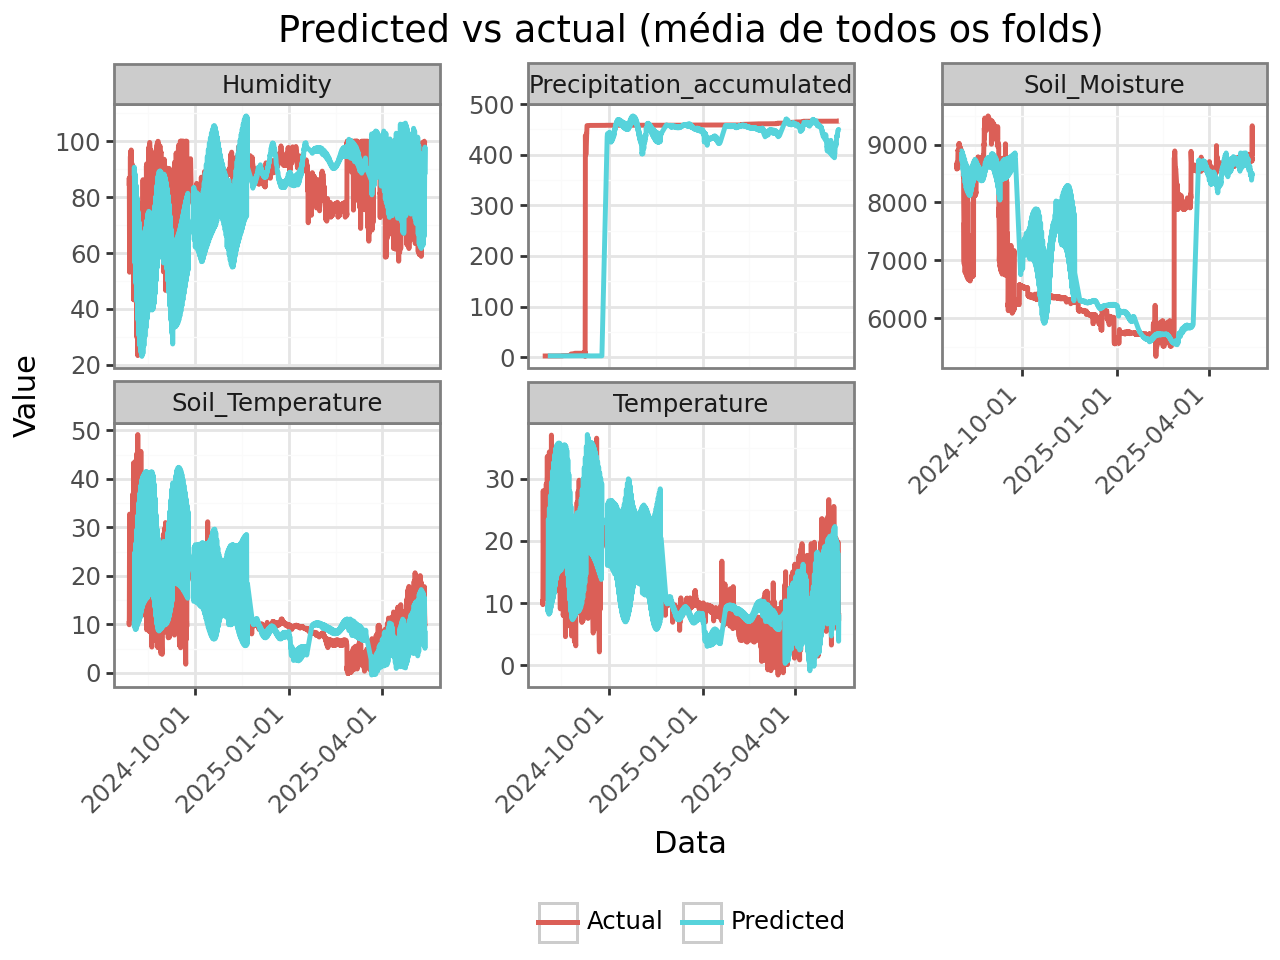

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


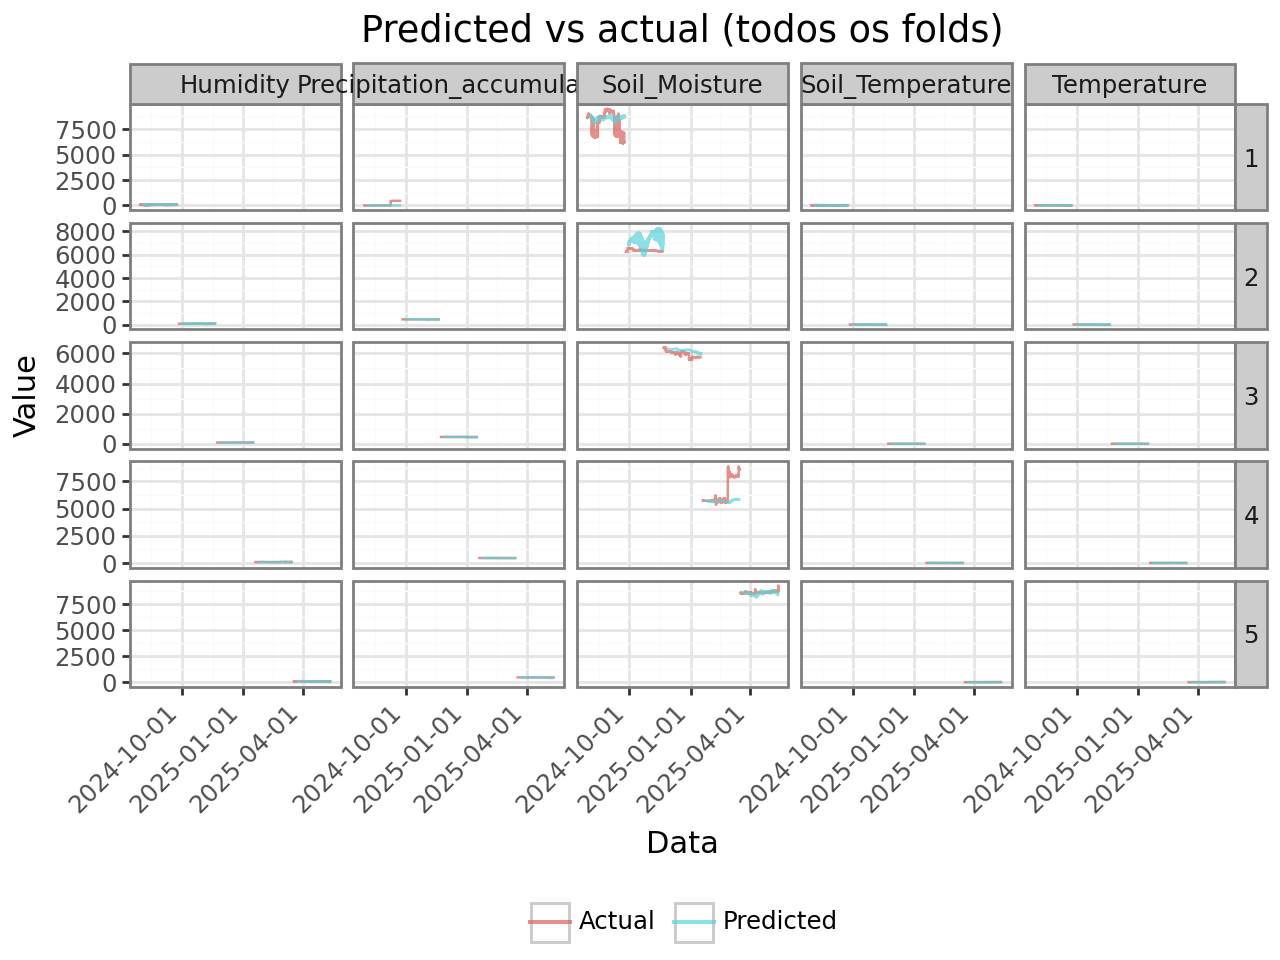

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_269988/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


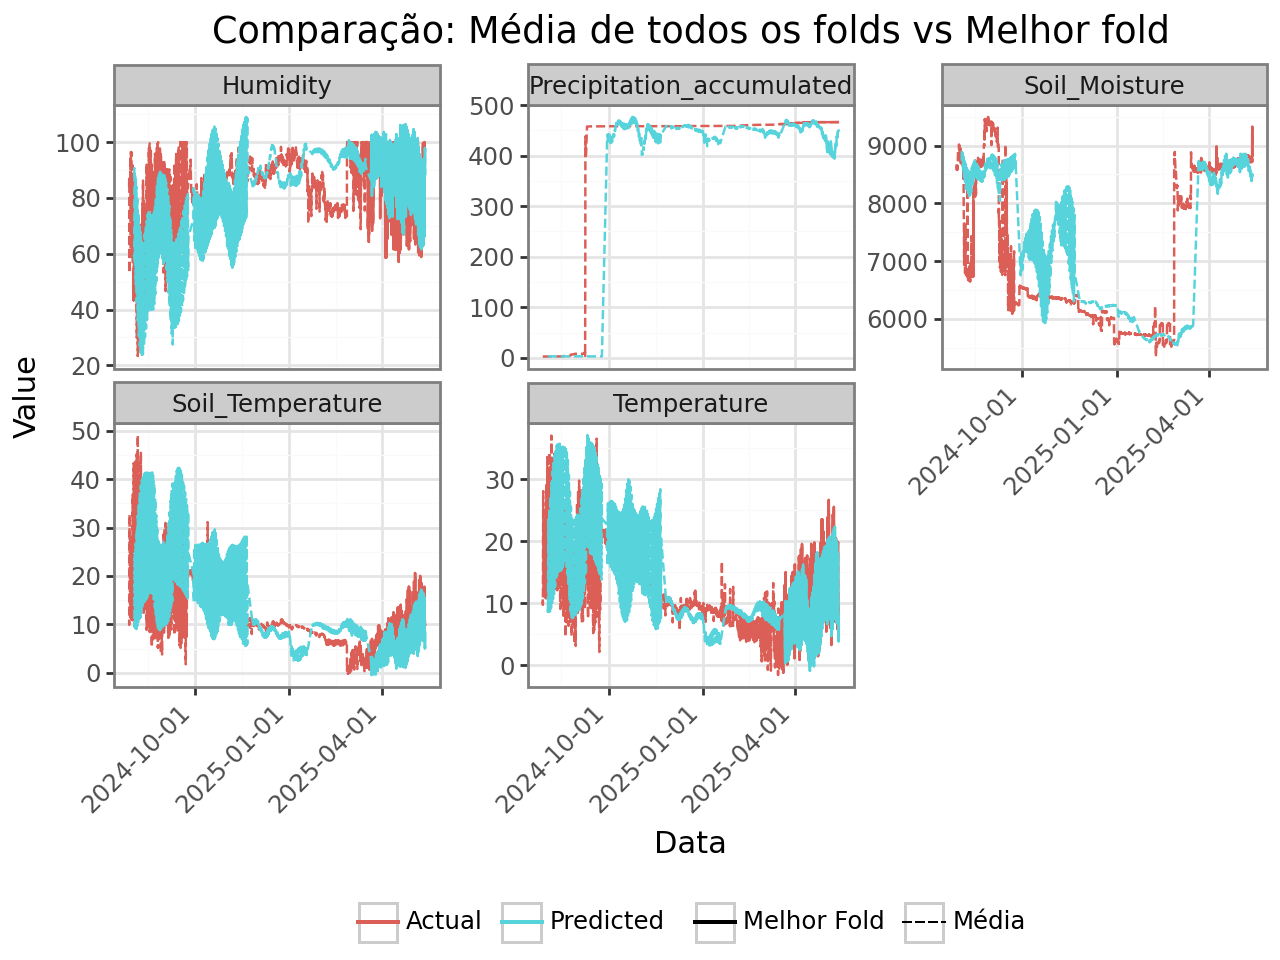

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [40]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [41]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
